## Introduction
This project is from Udacity free course A/B Testing by Google.

Udacity conducted an Free Trial Screener experiment. In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free. At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead.

More details of the project can be found here: https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub

## Experiment Design

### Unit of Diversion 
The unit of diversion is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

### Hypothesis
- Null Hypothesis: There is no difference in control group and treatment group.
- Alternative Hypothesis: There is a difference in control group and treatment group.

### Metrics Choice
A/B Testing requires two types of metrics: Invariant Metrics and Evaluation Metrics.

Available Metrics from Udacity:
- Number of cookies: That is, number of unique cookies to view the course overview page. (dmin=3000)
- Number of user-ids: That is, number of users who enroll in the free trial. (dmin=50)
- Number of clicks: That is, number of unique cookies to click the "Start free trial" button (which happens before the free trial screener is trigger). (dmin=240)
- Click-through-probability: That is, number of unique cookies to click the "Start free trial" button divided by number of unique cookies to view the course overview page. (dmin=0.01)
- Gross conversion: That is, number of user-ids to complete checkout and enroll in the free trial divided by number of unique cookies to click the "Start free trial" button. (dmin= 0.01)
- Retention: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of user-ids to complete checkout. (dmin=0.01)
- Net conversion: That is, number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the "Start free trial" button. (dmin= 0.0075)

#### Invariant Metrics
The invariant metrics are metrics that should not change in the experiment. And they will be used for sanity check.

The following metrics can be used as invariant metrics:
- Number of cookies: this is the population metrics, also it's the metric recorded before the Experiment Change happens.
- Number of clicks: it's the metric recorded before the Experiment Change happens.
- Click-through-probability: it's the ratio of the above 2 metrics.

#### Evaluation Metrics
- Gross conversion: used to measure the effect of the experiment change.
- Retension: used to measure the effect of the experiment change.
- Net conversion: used to measure the effect of the experiment change.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# import baseline values
baseline = pd.read_csv('Project Baseline Values.csv', header=None)
baseline

,0,1
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [3]:
# update baseline table
baseline.columns = ['metric', 'value']
baseline['metric'] = ['cookies', 'clicks', 'users','CTR','gross_conversion','retention','net_conversion']
baseline['dmin'] = [3000, 240, 50, 0.01, 0.01, 0.01, 0.0075]
baseline

,metric,value,dmin
0,cookies,40000.000000,3000.0000
1,clicks,3200.000000,240.0000
2,users,660.000000,50.0000
3,CTR,0.080000,0.0100
4,gross_conversion,0.206250,0.0100
5,retention,0.530000,0.0100
6,net_conversion,0.109313,0.0075


In [4]:
# for a sample size of 5,000 cookies, calculate the corresponding scaled value
baseline['scaled_value'] = np.nan
scale = 5000/40000

for i in range(3):
    baseline.loc[i, 'scaled_value'] = scale * baseline.loc[i, 'value']

In [5]:
baseline

,metric,value,dmin,scaled_value
0,cookies,40000.000000,3000.0000,5000.0
1,clicks,3200.000000,240.0000,400.0
2,users,660.000000,50.0000,82.5
3,CTR,0.080000,0.0100,NaN
4,gross_conversion,0.206250,0.0100,NaN
5,retention,0.530000,0.0100,NaN
6,net_conversion,0.109313,0.0075,NaN


#### Standard Error
To calculate the standard error of gross conversion, retention, and net conversion, assume the ditsributions of these metrics are approximately normal (binomial distribution). In binomial distribution, the standard error = sqrt(p(1-p)/n).

In [6]:
baseline['standard_error'] = np.nan
for i,j in zip([1,2,1],[4,5,6]):
    p = baseline.loc[j, 'value']
    n = baseline.loc[i, 'scaled_value']
    baseline.loc[j, 'standard_error'] = math.sqrt(p*(1-p)/n)

In [7]:
baseline

,metric,value,dmin,scaled_value,standard_error
0,cookies,40000.000000,3000.0000,5000.0,NaN
1,clicks,3200.000000,240.0000,400.0,NaN
2,users,660.000000,50.0000,82.5,NaN
3,CTR,0.080000,0.0100,NaN,NaN
4,gross_conversion,0.206250,0.0100,NaN,0.020231
5,retention,0.530000,0.0100,NaN,0.054949
6,net_conversion,0.109313,0.0075,NaN,0.015602


### Sizing

#### Sample Size
Here use an alpha of 0.05 and a beta of 0.2, how many pageviews total (across both groups) needed to collect to adequately power the experiment?

You could use Evan's Awesome A/B Tools (https://www.evanmiller.org/ab-testing/sample-size.html) to calculate the minimum sample size.

Key Inputs for Sample Size Calculation:
- Baseline Conversion Rate (
𝑝
1
 ): The current conversion rate (or other metric) of the control group.
- Minimum Detectable Effect (MDE): The smallest change in the metric (e.g., conversion rate) that you want to detect. It is usually expressed as a percentage increase or absolute difference from the baseline rate.
- Significance Level (
𝛼
): The probability of rejecting the null hypothesis when it is actually true (Type I error). Common values are 0.05 (5%) or 0.01 (1%).
- Statistical Power (
1
−
𝛽
): The probability of correctly detecting a true effect (1 minus the Type II error rate). Commonly used values for power are 0.8 (80%) or 0.9 (90%).

<img src="image.png">

In [8]:
import scipy.stats as stats
import math

def calculate_sample_size(baseline_rate, mde, significance_level=0.05, power=0.8):
    
    # Convert significance level and power to Z-scores
    alpha_z = stats.norm.ppf(1 - significance_level / 2)  # two-tailed test
    beta_z = stats.norm.ppf(power)

    # Calculate the average conversion rate
    p1 = baseline_rate
    p2 = baseline_rate + mde
    pooled_prob = (p1 + p2) / 2

    # Calculate the sample size for each group
    numerator = (alpha_z * math.sqrt(2 * pooled_prob * (1 - pooled_prob)) + 
                 beta_z * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2
    denominator = (p2 - p1) ** 2
    sample_size_per_group = numerator / denominator

    return math.ceil(sample_size_per_group)

In [9]:
baseline['sample_size'] = np.nan
for i in [4,5,6]:
    baseline_rate = baseline.loc[i, 'value']
    mde = baseline.loc[i, 'dmin']
    baseline.loc[i, 'sample_size'] = calculate_sample_size(baseline_rate, mde, significance_level=0.05, power=0.8)

In [10]:
baseline

,metric,value,dmin,scaled_value,standard_error,sample_size
0,cookies,40000.000000,3000.0000,5000.0,NaN,NaN
1,clicks,3200.000000,240.0000,400.0,NaN,NaN
2,users,660.000000,50.0000,82.5,NaN,NaN
3,CTR,0.080000,0.0100,NaN,NaN,NaN
4,gross_conversion,0.206250,0.0100,NaN,0.020231,26155.0
5,retention,0.530000,0.0100,NaN,0.054949,39051.0
6,net_conversion,0.109313,0.0075,NaN,0.015602,27984.0


In [11]:
# For gross conversion
sample_size = 26155
n_group = 2 # numer of groups
total_sample = sample_size * n_group

CTR = 0.08 # click through rate
pageviews1 = total_sample / CTR

In [12]:
# For retention
sample_size = 39051
n_group = 2 # numer of groups
total_sample = sample_size * n_group

user_per_cookie = 660/40000
pageviews2 = total_sample / user_per_cookie

In [13]:
# For net conversion
sample_size = 27984
n_group = 2 # numer of groups
total_sample = sample_size * n_group

CTR = 0.08 # click through rate
pageviews3 = total_sample / CTR

In [14]:
baseline['pageviews'] = np.nan
baseline.loc[4, 'pageviews'] = pageviews1
baseline.loc[5, 'pageviews'] = pageviews2
baseline.loc[6, 'pageviews'] = pageviews3
baseline

,metric,value,dmin,scaled_value,standard_error,sample_size,pageviews
0,cookies,40000.000000,3000.0000,5000.0,NaN,NaN,NaN
1,clicks,3200.000000,240.0000,400.0,NaN,NaN,NaN
2,users,660.000000,50.0000,82.5,NaN,NaN,NaN
3,CTR,0.080000,0.0100,NaN,NaN,NaN,NaN
4,gross_conversion,0.206250,0.0100,NaN,0.020231,26155.0,6.538750e+05
5,retention,0.530000,0.0100,NaN,0.054949,39051.0,4.733455e+06
6,net_conversion,0.109313,0.0075,NaN,0.015602,27984.0,6.996000e+05


Given the reuslts above, to test all 3 metrics, we need 4,733,455 pageviews in total.

#### Duration and Exposure
Considering we only have 40,000 pageviews (unique cookies) per day, if we assign 50% daily traffic to this experiment, how many days needed to run the experiment for each metric?

In [15]:
baseline['duration'] = np.nan
baseline.loc[4, 'duration'] = math.ceil(baseline.loc[4, 'pageviews']/(40000*0.5))
baseline.loc[5, 'duration'] = math.ceil(baseline.loc[5, 'pageviews']/(40000*0.5))
baseline.loc[6, 'duration'] = math.ceil(baseline.loc[6, 'pageviews']/(40000*0.5))
baseline

,metric,value,dmin,scaled_value,standard_error,sample_size,pageviews,duration
0,cookies,40000.000000,3000.0000,5000.0,NaN,NaN,NaN,NaN
1,clicks,3200.000000,240.0000,400.0,NaN,NaN,NaN,NaN
2,users,660.000000,50.0000,82.5,NaN,NaN,NaN,NaN
3,CTR,0.080000,0.0100,NaN,NaN,NaN,NaN,NaN
4,gross_conversion,0.206250,0.0100,NaN,0.020231,26155.0,6.538750e+05,33.0
5,retention,0.530000,0.0100,NaN,0.054949,39051.0,4.733455e+06,237.0
6,net_conversion,0.109313,0.0075,NaN,0.015602,27984.0,6.996000e+05,35.0


For retention, it requires a munimum of 237 days, which is way too long. Hence, we have to abandon this metric. 

As a result, we will run the experiment for 35 days with 50% daily traffic for gross conversion and net conversion.

## Results Analysis
After running the experiment, we have 2 datasets, one for the experiment group, and one for the control group.

The meaning of each column is:

- Pageviews: Number of unique cookies to view the course overview page that day.
- Clicks: Number of unique cookies to click the course overview page that day.
- Enrollments: Number of user-ids to enroll in the free trial that day.
- Payments: Number of user-ids who who enrolled on that day to remain enrolled for 14 days and thus make a payment. (Note that the date for this column is the start date, that is, the date of enrollment, rather than the date of the payment. The payment happened 14 days later. Because of this, the enrollments and payments are tracked for 14 fewer days than the other columns.)

In [16]:
control = pd.read_csv('Project Results - Control.csv')
experiment = pd.read_csv('Project Results - Experiment.csv')

In [17]:
len(control)

37

In [18]:
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [19]:
experiment.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


### Visualizations

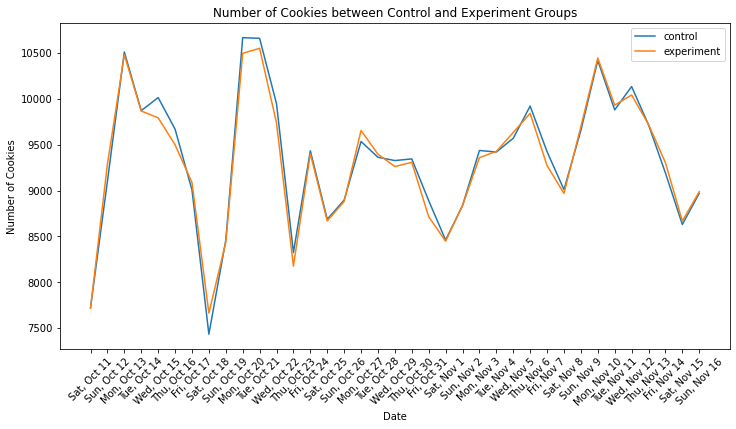

In [20]:
# invariant: Pageviews
plt.figure(figsize=(12,6))
plt.plot(control['Date'].values ,control['Pageviews'].values,label = 'control')
plt.plot(control['Date'].values ,experiment['Pageviews'].values, label = 'experiment')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of Cookies')
plt.title('Number of Cookies between Control and Experiment Groups')
plt.legend()

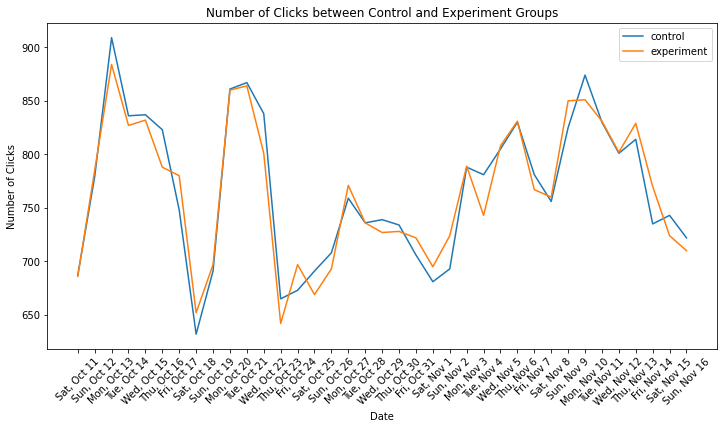

In [21]:
# invariant: Clicks
plt.figure(figsize=(12,6))
plt.plot(control['Date'].values ,control['Clicks'].values,label = 'control')
plt.plot(control['Date'].values ,experiment['Clicks'].values, label = 'experiment')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of Clicks')
plt.title('Number of Clicks between Control and Experiment Groups')
plt.legend()

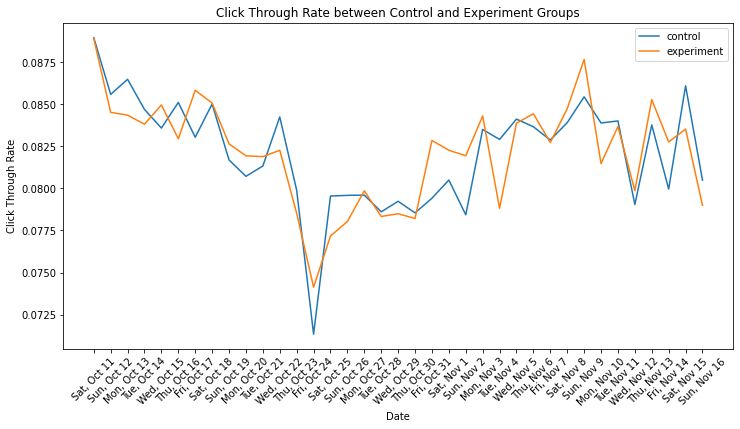

In [22]:
# invariant: click through rate (Number of clicks / Number of cookies)
plt.figure(figsize=(12,6))
plt.plot(control['Date'].values,control['Clicks'].values/control['Pageviews'].values,label = 'control')
plt.plot(control['Date'].values ,experiment['Clicks'].values/experiment['Pageviews'].values, label = 'experiment') 
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Click Through Rate')
plt.title('Click Through Rate between Control and Experiment Groups')
plt.legend()

### Sanity Check

#### Sanity Check for Pageviews
The pageviews should be equally split between the control and experiment groups. The expected proportion for each group is 50%.

<img src="pageview.png">

In [23]:
from scipy.stats import norm

def sanity_check(counts_control, counts_experiment, expected_proportion=0.5, confidence_level=0.95):
    # Total count
    total_counts = counts_control + counts_experiment
    
    # standard error
    se = np.sqrt(expected_proportion * (1 - expected_proportion) / total_counts)
    
    # Z critical value
    z_critical = norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Margin of error
    margin_of_error = z_critical * se
    
    # Observed proportion in the control group
    observed_proportion = counts_control / total_counts
    
    # Confidence interval
    lower_bound = expected_proportion - margin_of_error
    upper_bound = expected_proportion + margin_of_error
    
    print(f"Observed Proportion (Control): {observed_proportion:.4f}")
    print(f"{confidence_level*100:.0f}% Confidence Interval for Pageviews: [{lower_bound:.4f}, {upper_bound:.4f}]")
    
    if lower_bound <= observed_proportion <= upper_bound:
        print("Sanity check passes: The observed proportion is within the confidence interval.")
    else:
        print("Sanity check fails: The observed proportion is outside the confidence interval.")
    
    return lower_bound, upper_bound, observed_proportion, lower_bound <= observed_proportion <= upper_bound

In [24]:
lower_bound, upper_bound, observed_proportion, check = \
sanity_check(control['Pageviews'].sum(), experiment['Pageviews'].sum(), expected_proportion=0.5, confidence_level=0.95)

Observed Proportion (Control): 0.5006
95% Confidence Interval for Pageviews: [0.4988, 0.5012]
Sanity check passes: The observed proportion is within the confidence interval.


In [25]:
pageviews = {'metric':['pageviews'], 'lower_bound': [lower_bound], 'upper_bound': [upper_bound],
            'observed':[observed_proportion], 'pass':[check]}
df_pageviews = pd.DataFrame(pageviews)

In [26]:
df_pageviews

,metric,lower_bound,upper_bound,observed,pass
0,pageviews,0.49882,0.50118,0.50064,True


#### Sanity Check for Clicks
Same as Pageviews, Clicks should be equally split between the control and experiment groups. The expected proportion for each group is 50%.

In [27]:
lower_bound, upper_bound, observed_proportion, check = \
sanity_check(control['Clicks'].sum(), experiment['Clicks'].sum(), expected_proportion=0.5, confidence_level=0.95)

Observed Proportion (Control): 0.5005
95% Confidence Interval for Pageviews: [0.4959, 0.5041]
Sanity check passes: The observed proportion is within the confidence interval.


In [28]:
clicks = {'metric':['clicks'], 'lower_bound': [lower_bound], 'upper_bound': [upper_bound],
            'observed':[observed_proportion], 'pass':[check]}
df_clicks = pd.DataFrame(clicks)

In [29]:
df_clicks

,metric,lower_bound,upper_bound,observed,pass
0,clicks,0.495885,0.504115,0.500467,True


#### Sanity Check for CTR
To perform a sanity check using confidence intervals, you can calculate the confidence interval for the difference in click-through rates (CTR) between the control and experiment groups. If the confidence interval includes zero, it suggests that there is no statistically significant difference between the two groups, thus passing the sanity check.

<img src='ctr.png'>

In [30]:
def sanity_check_ctr(clicks_control, pageviews_control, clicks_experiment, pageviews_experiment, confidence_level=0.95):
    # Calculate CTR for each group
    ctr_control = clicks_control / pageviews_control
    ctr_experiment = clicks_experiment / pageviews_experiment
    
    # Calculate the pooled CTR
    ctr_pooled = (clicks_control + clicks_experiment) / (pageviews_control + pageviews_experiment)
    
    # Calculate the standard error
    se = np.sqrt(ctr_pooled * (1 - ctr_pooled) * (1/pageviews_control + 1/pageviews_experiment))
    
    # Calculate the z critical value for the given confidence level
    z_critical = norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Calculate the margin of error
    margin_of_error = z_critical * se
    
    # Calculate the difference in CTRs
    ctr_diff = ctr_experiment - ctr_control
    
    # Calculate the confidence interval
    lower_bound = ctr_diff - margin_of_error
    upper_bound = ctr_diff + margin_of_error
    
    # Print the results
    print(f"CTR Control: {ctr_control:.4f}")
    print(f"CTR Experiment: {ctr_experiment:.4f}")
    print(f"Difference in CTRs: {ctr_diff:.4f}")
    print(f"{confidence_level*100:.0f}% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    
    # Determine if the sanity check passes
    if lower_bound <= 0 <= upper_bound:
        print("Sanity check passes: The confidence interval includes zero, indicating no significant difference.")
    else:
        print("Sanity check fails: The confidence interval does not include zero, indicating a significant difference.")
    
    return lower_bound, upper_bound, ctr_diff, lower_bound <= 0 <= upper_bound


In [31]:
lower_bound, upper_bound, observed_diff, check = \
sanity_check_ctr(control['Clicks'].sum(), control['Pageviews'].sum(), experiment['Clicks'].sum(), experiment['Pageviews'].sum(), confidence_level=0.95)

CTR Control: 0.0821
CTR Experiment: 0.0822
Difference in CTRs: 0.0001
95% Confidence Interval: [-0.0012, 0.0014]
Sanity check passes: The confidence interval includes zero, indicating no significant difference.


In [32]:
ctr = {'metric':['ctr'], 'lower_bound': [lower_bound], 'upper_bound': [upper_bound],
            'observed':[observed_diff], 'pass':[check]}
df_ctr = pd.DataFrame(ctr)

In [33]:
sanity_check = pd.concat([df_pageviews, df_clicks, df_ctr])
sanity_check

,metric,lower_bound,upper_bound,observed,pass
0,pageviews,0.498820,0.501180,0.500640,True
0,clicks,0.495885,0.504115,0.500467,True
0,ctr,-0.001239,0.001352,0.000057,True


Based on above results, we can conclude that all invariant metrics passed the sanity check.

### Evaluation Metrics Analysis

#### Visualizations

In [34]:
# remove days without enrollments and payments data
control_sliced = control[:23]
experiment_sliced = experiment[:23]

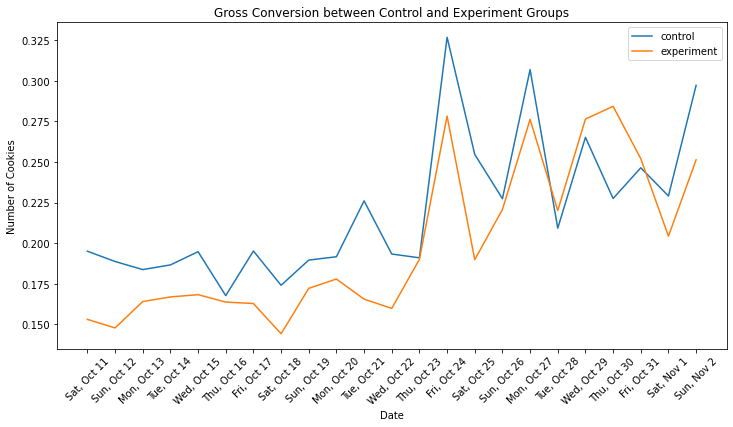

In [35]:
# evaluation metric: Gross Conversion
plt.figure(figsize=(12,6))
plt.plot(control_sliced['Date'].values,control_sliced['Enrollments'].values/control_sliced['Clicks'].values,label = 'control')
plt.plot(control_sliced['Date'].values,experiment_sliced['Enrollments'].values/experiment_sliced['Clicks'].values, label = 'experiment')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of Cookies')
plt.title('Gross Conversion between Control and Experiment Groups')
plt.legend()

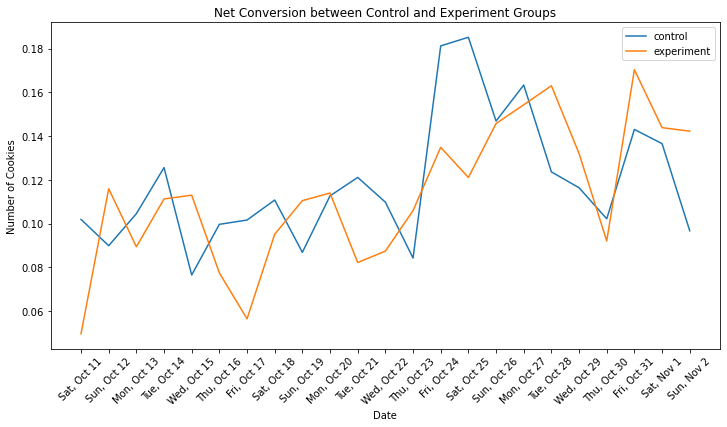

In [36]:
# evaluation metric: Net Conversion
plt.figure(figsize=(12,6))
plt.plot(control_sliced['Date'].values ,control_sliced['Payments'].values/control_sliced['Clicks'].values,label = 'control')
plt.plot(control_sliced['Date'].values ,experiment_sliced['Payments'].values/experiment_sliced['Clicks'].values, label = 'experiment')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of Cookies')
plt.title('Net Conversion between Control and Experiment Groups')
plt.legend()

#### Practical and Statistical Significance
For evaluation metrics, calculate a confidence interval for the difference between the experiment and control groups, and check whether each metric is statistically and/or practically significance. A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)

In [45]:
def significance_check(numerator_control, denominator_control, numerator_experiment, denominator_experiment, practical_significance, confidence_level=0.95):
    # Calculate conversion rate for each group
    conversion_control = numerator_control / denominator_control
    conversion_experiment = numerator_experiment / denominator_experiment
    
    # Calculate the pooled conversion rate
    conversion_pooled = (numerator_control + numerator_experiment) / (denominator_control + denominator_experiment)
    
    # Calculate the standard error
    se = np.sqrt(conversion_pooled * (1 - conversion_pooled) * (1/denominator_control + 1/denominator_experiment))
    
    # Calculate the z critical value for the given confidence level
    z_critical = norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Calculate the margin of error
    margin_of_error = z_critical * se
    
    # Calculate the difference in conversion rate
    conversion_diff = conversion_experiment - conversion_control
    
    # Calculate the confidence interval
    lower_bound = conversion_diff - margin_of_error
    upper_bound = conversion_diff + margin_of_error
    
    # Print the results
    print(f"Conversion Control: {conversion_control:.4f}")
    print(f"Conversion Experiment: {conversion_experiment:.4f}")
    print(f"Difference in convertion: {conversion_diff:.4f}")
    print(f"{confidence_level*100:.0f}% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    
    # Determine if statistical significant
    if lower_bound <= 0 <= upper_bound:
        print("Statistical significant difference is false.")
    else:
        print("Statistical significant difference is true.")
        
    # Determine if practical significant
    if upper_bound < -practical_significance or lower_bound > practical_significance:
        print("Practical significant difference is true.")
    else:
        print("Practical significant difference is false.")
    
    return lower_bound, upper_bound, conversion_diff, not(lower_bound <= 0 <= upper_bound), (upper_bound < -practical_significance or lower_bound > practical_significance)

In [38]:
baseline

,metric,value,dmin,scaled_value,standard_error,sample_size,pageviews,duration
0,cookies,40000.000000,3000.0000,5000.0,NaN,NaN,NaN,NaN
1,clicks,3200.000000,240.0000,400.0,NaN,NaN,NaN,NaN
2,users,660.000000,50.0000,82.5,NaN,NaN,NaN,NaN
3,CTR,0.080000,0.0100,NaN,NaN,NaN,NaN,NaN
4,gross_conversion,0.206250,0.0100,NaN,0.020231,26155.0,6.538750e+05,33.0
5,retention,0.530000,0.0100,NaN,0.054949,39051.0,4.733455e+06,237.0
6,net_conversion,0.109313,0.0075,NaN,0.015602,27984.0,6.996000e+05,35.0


In [39]:
control_sliced.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [46]:
# Gross Conversion
lower_bound, upper_bound, conversion_diff, statistical_significance, practical_significance = \
significance_check(control_sliced['Enrollments'].sum(), control_sliced['Clicks'].sum(), 
                   experiment_sliced['Enrollments'].sum(), experiment_sliced['Clicks'].sum(), 
                   baseline.loc[4, 'dmin'], confidence_level=0.95)

Conversion Control: 0.2189
Conversion Experiment: 0.1983
Difference in convertion: -0.0206
95% Confidence Interval: [-0.0291, -0.0120]
Statistical significant difference is true.
Practical significant difference is true.


In [47]:
gross_conversion = {'metric':['gross_conversion'], 'lower_bound': [lower_bound], 'upper_bound': [upper_bound],'conversion_diff':[conversion_diff], 
                    'statistical_significance':[statistical_significance], 'practical_significance':[practical_significance]}
df_gross = pd.DataFrame(gross_conversion)

In [48]:
# Net Conversion
lower_bound, upper_bound, conversion_diff, statistical_significance, practical_significance = \
significance_check(control_sliced['Payments'].sum(), control_sliced['Clicks'].sum(), 
                   experiment_sliced['Payments'].sum(), experiment_sliced['Clicks'].sum(), 
                   baseline.loc[6, 'dmin'], confidence_level=0.95)

Conversion Control: 0.1176
Conversion Experiment: 0.1127
Difference in convertion: -0.0049
95% Confidence Interval: [-0.0116, 0.0019]
Statistical significant difference is false.
Practical significant difference is false.


In [49]:
net_conversion = {'metric':['net_conversion'], 'lower_bound': [lower_bound], 'upper_bound': [upper_bound],'conversion_diff':[conversion_diff], 
                    'statistical_significance':[statistical_significance], 'practical_significance':[practical_significance]}
df_net = pd.DataFrame(net_conversion)

In [50]:
evaluation_metrics = pd.concat([df_gross, df_net])
evaluation_metrics

,metric,lower_bound,upper_bound,conversion_diff,statistical_significance,practical_significance
0,gross_conversion,-0.029123,-0.011987,-0.020555,True,True
0,net_conversion,-0.011605,0.001857,-0.004874,False,False


Based on the above results, Gross Conversion is statistical and pratical significant, and Net Conversion is not statistical and practical significant.

### Sign Test
How the Sign Test Works:
- Calculate the Difference: For each pair of observations, calculate the difference between the two values (e.g., after - before).
- Assign Signs: Record whether each difference is positive (+), negative (−), or zero (0). Ignore pairs with a difference of zero, as they do not contribute to the test.
- Count the Signs: Count the number of positive differences and the number of negative differences.
- Perform the Test:
The test checks whether the number of positive differences is significantly different from the number of negative differences.
Under the null hypothesis, there is no difference between the paired observations, so the number of positive and negative differences should be approximately equal.


In [61]:
from scipy.stats import binomtest

def sign_test(control_group:np.array, experiment_group:np.array):
    
    """
    use binom_test to perform a two-sided sign test. 
    Under the null hypothesis, the probability of getting a positive or negative difference is 0.5.
    """
    
    # Calculate the differences
    differences = experiment_group - control_group

    # Count the number of positive and negative signs (ignore zero differences)
    num_positive = np.sum(differences > 0)
    num_negative = np.sum(differences < 0)

    # Perform the sign test using binom_test (two-sided test)
    result = binomtest(num_positive, n=num_positive + num_negative, p=0.5, alternative='two-sided')

    # Output results
    print(f"Number of positive differences: {num_positive}")
    print(f"Number of negative differences: {num_negative}")
    print(f"P-value from the sign test: {result.pvalue:.4f}")

    # Interpretation
    if result.pvalue < 0.05:
        print("There is a statistically significant difference between control group and experiment group.")
    else:
        print("There is no statistically significant difference between control group and experiment group.")


In [62]:
# sign test for gross conversion
gross_conversion_control = np.array(control_sliced['Enrollments'] / control_sliced['Clicks'])
gross_conversion_experiment = np.array(experiment_sliced['Enrollments'] / experiment_sliced['Clicks'])

print('For Gross Conversion:')
sign_test(gross_conversion_control, gross_conversion_experiment)

For Gross Conversion:
Number of positive differences: 4
Number of negative differences: 19
P-value from the sign test: 0.0026
There is a statistically significant difference between control group and experiment group.


In [64]:
# sign test for net conversion
net_conversion_control = np.array(control_sliced['Payments'] / control_sliced['Clicks'])
net_conversion_experiment = np.array(experiment_sliced['Payments'] / experiment_sliced['Clicks'])

print('For Net Conversion:')
sign_test(net_conversion_control, net_conversion_experiment)

For Net Conversion:
Number of positive differences: 10
Number of negative differences: 13
P-value from the sign test: 0.6776
There is no statistically significant difference between control group and experiment group.
